## Playing card detection image Dataset

In [666]:
! pip install cjm_pil_utils cjm_psl_utils cjm_pytorch_utils cjm_torchvision_tfms

In [667]:
# some tools:
from functools import partial
from cjm_psl_utils.core import download_file, file_extract
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import cv2 as cv
# from google.colab.patches import cv2_imshow
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.autograd import Variable
from pytorch_lightning import loggers as pl_loggers


# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms

#### - first let's get familiar with the dataset
- Dataset path: /Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/centernetImplementation/centernet/cardDetectionDataset/

first lets plot a few raw images:

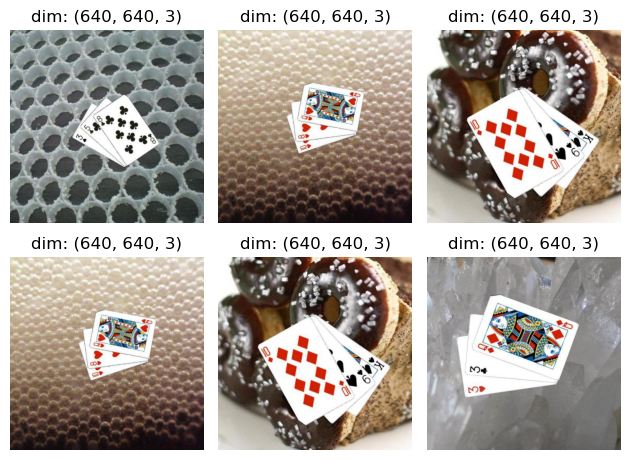

In [668]:
# Open an image file
BASE_PATH = "/Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/centernetImplementation/centernet/cardDetectionDataset/"
TEST_PATH =  BASE_PATH + "test/"
TRAIN_PATH = BASE_PATH + "train/"
VAL_PATH = BASE_PATH + "valid/"

img_name_lst = [
 '001783412_jpg.rf.71fa67222c66ff7f2f6ef5201d82b8e7.jpg', 
 '281749562_jpg.rf.27184507cc5c7091769da3975f49a0a9.jpg',
 '650251706_jpg.rf.f37903f8f141a7172791132ce3857899.jpg', 
 '277293160_jpg.rf.f64c244cc7484dd95edf97b9460a63f9.jpg',
 '633426926_jpg.rf.c709fb5dd4103b0e0286f769c2d77f67.jpg',
 '970552017_jpg.rf.856c2b112e9f438b82af0b574e7ecd7f.jpg'
 ]


img_lst = [np.array(Image.open(TEST_PATH + img_name)) for img_name in img_name_lst]

rows = int(len(img_lst) / (len(img_lst) / 2))
cols = int(len(img_lst) / 2)

fig, axes = plt.subplots(rows, cols)

for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(img_lst[i + j])
        axes[i, j].axis('off')  # Remove ticks
        axes[i, j].set_title(f'dim: {img_lst[i + j].shape}')
    
plt.tight_layout()
plt.show()


In [669]:
ntrain_sample = len(os.listdir(TEST_PATH)) - 1 # for the annotation file
ntest_sample = len(os.listdir(TRAIN_PATH)) - 1
nval_sample = len(os.listdir(VAL_PATH)) - 1

print('number of train sample:', ntrain_sample)
print('number of test sample:', ntest_sample)
print('number of val sample:', nval_sample)

print('total:', ntrain_sample + ntest_sample + nval_sample)

number of train sample: 448
number of test sample: 8716
number of val sample: 835
total: 9999


#### How to read the annotations file ? (JSON COCO format)
--> https://roboflow.com/formats/coco-json

1. open the file and read it using a JSON parser
2. there is only 5 categories: ['info', 'licenses', 'categories', 'images', 'annotations']

In [670]:
import json

with open(TRAIN_PATH + '_annotations.coco.json', 'r') as f:
    datas = json.load(f)

classes = datas['categories']
print('o classes keys:', classes[0].keys(), 'classes len:', len(classes))

imgs = datas['images']
print('o imgs keys:', imgs[0].keys(), 'images len:', len(imgs))

annotations = datas['annotations']
print('o annotations format:', annotations[0].keys(), 'annotations len:', len(annotations))

o classes keys: dict_keys(['id', 'name', 'supercategory']) classes len: 53
o imgs keys: dict_keys(['id', 'license', 'file_name', 'height', 'width', 'date_captured']) images len: 8716
o annotations format: dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd']) annotations len: 34853


#### CLASSES

In [671]:
for idx, classe in enumerate(classes):
    print('id --> ', idx, classe['id'])
    print('name --> ', classe['name'], end='\n\n')
   


id -->  0 0
name -->  playing-cards

id -->  1 1
name -->  10C

id -->  2 2
name -->  10D

id -->  3 3
name -->  10H

id -->  4 4
name -->  10S

id -->  5 5
name -->  2C

id -->  6 6
name -->  2D

id -->  7 7
name -->  2H

id -->  8 8
name -->  2S

id -->  9 9
name -->  3C

id -->  10 10
name -->  3D

id -->  11 11
name -->  3H

id -->  12 12
name -->  3S

id -->  13 13
name -->  4C

id -->  14 14
name -->  4D

id -->  15 15
name -->  4H

id -->  16 16
name -->  4S

id -->  17 17
name -->  5C

id -->  18 18
name -->  5D

id -->  19 19
name -->  5H

id -->  20 20
name -->  5S

id -->  21 21
name -->  6C

id -->  22 22
name -->  6D

id -->  23 23
name -->  6H

id -->  24 24
name -->  6S

id -->  25 25
name -->  7C

id -->  26 26
name -->  7D

id -->  27 27
name -->  7H

id -->  28 28
name -->  7S

id -->  29 29
name -->  8C

id -->  30 30
name -->  8D

id -->  31 31
name -->  8H

id -->  32 32
name -->  8S

id -->  33 33
name -->  9C

id -->  34 34
name -->  9D

id -->  35 35
name -->  9

#### IMAGES

In [672]:
for i in range(10):
    print('image_id:', imgs[i]['id'], '\nfilename:', imgs[i]['file_name'], '\nheight/width:', imgs[i]['height'], imgs[i]['width'], end='\n\n')

image_id: 0 
filename: 682264987_jpg.rf.00057ccc573ad4ebded0239e2ccf9ee2.jpg 
height/width: 640 640

image_id: 1 
filename: 632636623_jpg.rf.000ce9e537666eb240ed2327948581f6.jpg 
height/width: 640 640

image_id: 2 
filename: 980463715_jpg.rf.001c5554677d9ed45514c7f62412998c.jpg 
height/width: 640 640

image_id: 3 
filename: 691548109_jpg.rf.005d055f3550394e30fe70f704307a95.jpg 
height/width: 640 640

image_id: 4 
filename: 684177091_jpg.rf.0035ae07f9b8f5a22e13e023a5ac109d.jpg 
height/width: 640 640

image_id: 5 
filename: 417281064_jpg.rf.000ebde59f566e54777a07f1575659a6.jpg 
height/width: 640 640

image_id: 6 
filename: 919408329_jpg.rf.0045ee0f77203092a27276441a5d5d8f.jpg 
height/width: 640 640

image_id: 7 
filename: 595262394_jpg.rf.0016ef0fd01561362ec1ce8254b4868b.jpg 
height/width: 640 640

image_id: 8 
filename: 811814590_jpg.rf.005ca672eb5d7c79c6ce30719f8cf8bd.jpg 
height/width: 640 640

image_id: 9 
filename: 288824675_jpg.rf.0047d188f6a9efe14646cbcea7cfaf74.jpg 
height/width:

In [673]:
for i in range(5):
    print('-->', f'{annotations[i]['id']}', annotations[i]['bbox'])

# we have format [x, y, w, h] for bounding box annotation

--> 0 [323, 329, 30, 65]
--> 1 [379, 309, 40, 65]
--> 2 [443, 276, 48.5, 63]
--> 3 [465, 0, 48.5, 53]
--> 4 [350, 164, 34.5, 68.5]


### Visualize classes distribution

53
53
53


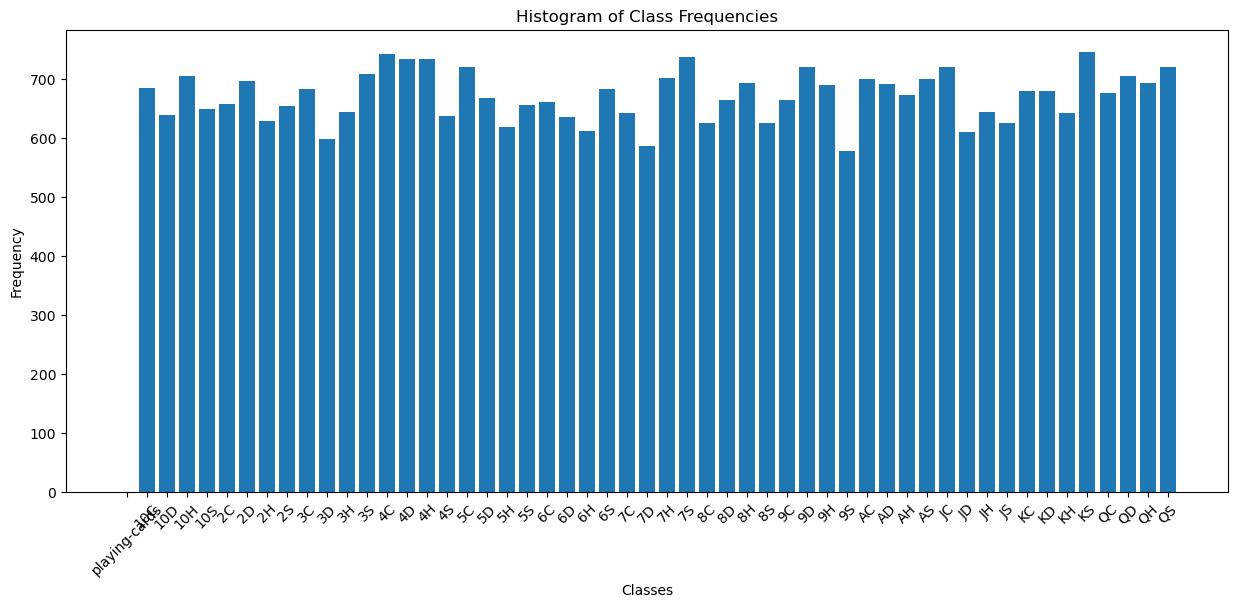

In [674]:
class_count = [0] * 53
classe_name = [c['name'] for c in classes]

print(len(classe_name))
print(len(classes))
print(len(class_count))

for annot in annotations:
     class_count[annot['category_id']] += 1

plt.figure(figsize=(15, 6))
plt.bar(classe_name, class_count)

plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Class Frequencies')

plt.xticks(rotation=45)
plt.show()





- #### lets take a few image and draw the bounding boxs
- #### but first we need to parse our datas for more convenience

In [675]:
images_list_parsed = []

for img in imgs:
    img_id, filename = img['id'], img['file_name']
    related_annotations = []
    for annot in annotations:
        if annot["image_id"] == img_id:
            related_annotations.append(dict( box=annot['bbox'], classe=annot['category_id'], area=annot['area']) )
    images_list_parsed.append(dict(id=img_id, filename=filename, labels=related_annotations))


    

In [676]:
print('nb image:', len(images_list_parsed))

total_annotation = np.array([len(img['labels']) for img in images_list_parsed]).sum()
average = total_annotation / len(images_list_parsed)
print('average bbox per image:', average)

nb image: 8716
average bbox per image: 3.9987379531895364


##### Reload to try different images

annotated_tensor.shape: torch.Size([3, 640, 640])


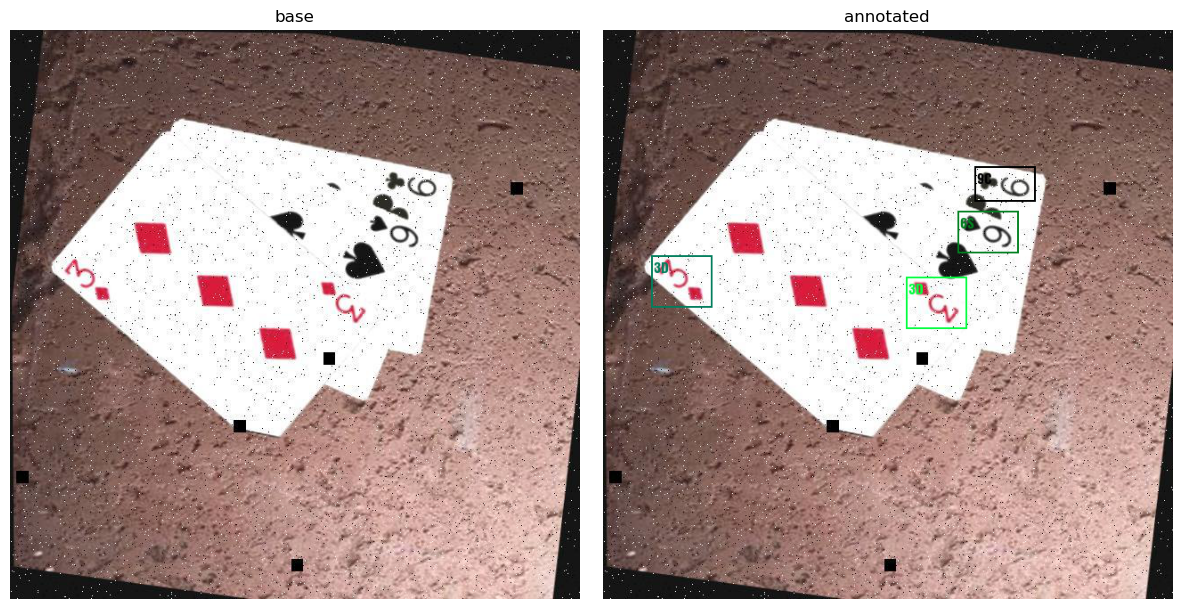

In [677]:
font_file = 'Oswald-Bold.ttf'

idx = np.random.randint(0, 8716)
sample_img = images_list_parsed[idx]
img = Image.open(TRAIN_PATH + sample_img['filename']).convert('RGB')

draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=15)

bboxes = [b['box'] for b in sample_img['labels']]
classe = [classes[ b['classe'] ]['name'] for b in sample_img['labels']]


annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'),
    labels=classe,
)

print('annotated_tensor.shape:', annotated_tensor.shape)

annotated_img = np.transpose(np.array(annotated_tensor), (1, 2, 0))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('base')

axs[1].imshow(annotated_img)
axs[1].axis('off')
axs[1].set_title('annotated')

plt.tight_layout()
plt.show()


### Let's generate our dataset

In [678]:


class CardDlayingDataset(Dataset):
    def __init__(self, path, transforms=None):

        self.path = path

        with open(self.path + '_annotations.coco.json', 'r') as f:
            datas = json.load(f)
        classes = datas['categories']
        imgs = datas['images']
        annotations = datas['annotations']
        
        self.parsed_datas = self._datas_parser(imgs, annotations)
        self.classes_names = [c['name'] for c in classes] # class_name are already in order

        
        self.size = len(self.parsed_datas)
        self.transforms = transforms
        
    def __getitem__(self, i):
        img = Image.open(self.path + self.parsed_datas[i]['filename']).convert('RGB')
        labels = self.parsed_datas[i]['labels']
        
        if self.transforms:
            bx = [b['box'] for b in labels] # [ [x,y,w,h], [x,y,w,h], ...]
            cid = [c['classe'] for c in labels] # [id, id, id, ..]

            # make it 'consumable' for our transformations 
            targets_data_struct = {
                'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bx), 'xywh', 'xyxy'),
                           format='xyxy',
                           canvas_size=img.size
                           ),
                'labels': torch.Tensor(cid)
            }

            img, labels = self.transforms(img, targets_data_struct)

        return (img, labels)

    def len(self):
        return self.size
    
    def _datas_parser(self, imgs, annotations):
        images_list_parsed = []

        for img in imgs:
            img_id, filename = img['id'], img['file_name']
            related_annotations = []
            for annot in annotations:
                if annot["image_id"] == img_id:
                    related_annotations.append(dict( box=annot['bbox'], classe=annot['category_id'], area=annot['area']) )
            images_list_parsed.append(dict(id=img_id, filename=filename, labels=related_annotations))

        return (images_list_parsed)

In [679]:
train_dataset = CardDlayingDataset(TRAIN_PATH)

In [680]:
img, labels = train_dataset[2]

<class 'PIL.Image.Image'>
<class 'list'>
labels in the image:
class: 15 --> 4H
box dim (x, y, h, w): [199, 153, 57.5, 53.5]
area: 3076.25 or h * w 3076.25
class: 38 --> AD
box dim (x, y, h, w): [160, 205, 63.5, 48.5]
area: 3079.75 or h * w 3079.75
class: 34 --> 9D
box dim (x, y, h, w): [134, 263, 67.5, 45]
area: 3037.5 or h * w 3037.5
class: 34 --> 9D
box dim (x, y, h, w): [274, 523, 68.5, 45]
area: 3082.5 or h * w 3082.5


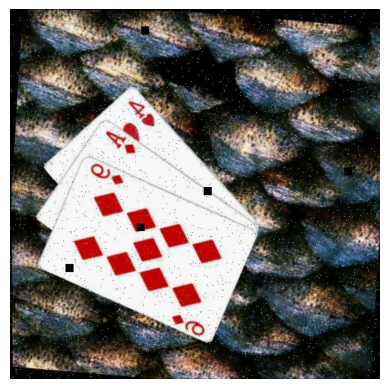

In [681]:
print(type(img))
print(type(labels))

img = np.array(img)

plt.imshow(img)
plt.axis('off')

print('labels in the image:')
for label in labels:
    print('class:', label['classe'], '-->', train_dataset.classes_names[label['classe']])
    print('box dim (x, y, h, w):', label['box'])
    print('area:', label['area'], 'or h * w', label['box'][2] * label['box'][3])

#### DATA AUGMENTATION


In [682]:
# first on an image sample

TRAIN_SIZE = 256

idx = 324
img, labels = train_dataset[idx]

# let's try the simplest form of augmentations pipeline: Random crop | Resize | padding
# w'll use three transformation class from the cjm lib: CustomRandomIoUCrop | ResizeMax | PadSquare

cropper = CustomRandomIoUCrop(min_scale = 0.3, # minimum downscaling factor relatively to the input img; here 30%
                              max_scale = 1.0, # maximum factor
                              min_aspect_ratio = 0.5, # width cant be less than 50% of the height
                              max_aspect_ratio = 2.0, # cant be greater than 100%
                              sampler_options = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], # controlling the probability of small IoU between box and ROI
                              trials = 400, # max trial for finding suitable crop
                              jitter_factor = 0.25 # randomness variance of the paramaters
                              )

resize_max = ResizeMax(max_sz = TRAIN_SIZE)

padder = PadSquare(shift=True) # preserve the center of the original image





In [683]:
# let's test our augmentations 

bboxes = [b['box'] for b in labels] # [ [x,y,w,h], [x,y,w,h], ...]

classes_id = [c['classe'] for c in labels]

classes_name = [train_dataset.classes_names[ c['classe'] ] for c in labels] # ['dame de coeur', '2 de trefle',  ... ]

targets_data_struct = {
    'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'),
                           format='xyxy',
                           canvas_size=img.size
                           ),
    'labels': torch.Tensor(classes_id)
}

cropped_img, cropped_labels = cropper(img, targets_data_struct)

resized_img, resized_labels = resize_max(cropped_img, cropped_labels)

padded_img, padded_labels = padder(resized_img, resized_labels)

# Ensure the padded image is the target size
resize = transforms.Resize([TRAIN_SIZE] * 2, antialias=True)
resized_padded_img, resize_padded_targets = resize(padded_img, padded_labels)
sanitized_img, sanitized_labels = transforms.SanitizeBoundingBoxes()(resized_padded_img, resize_padded_targets)

print(len(sanitized_labels['boxes']), len(sanitized_labels['labels']))
# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sanitized_img), 
    boxes=sanitized_labels['boxes'], 
    labels=[train_dataset.classes_names[int(c)] for c in sanitized_labels['labels']],
)






4 4


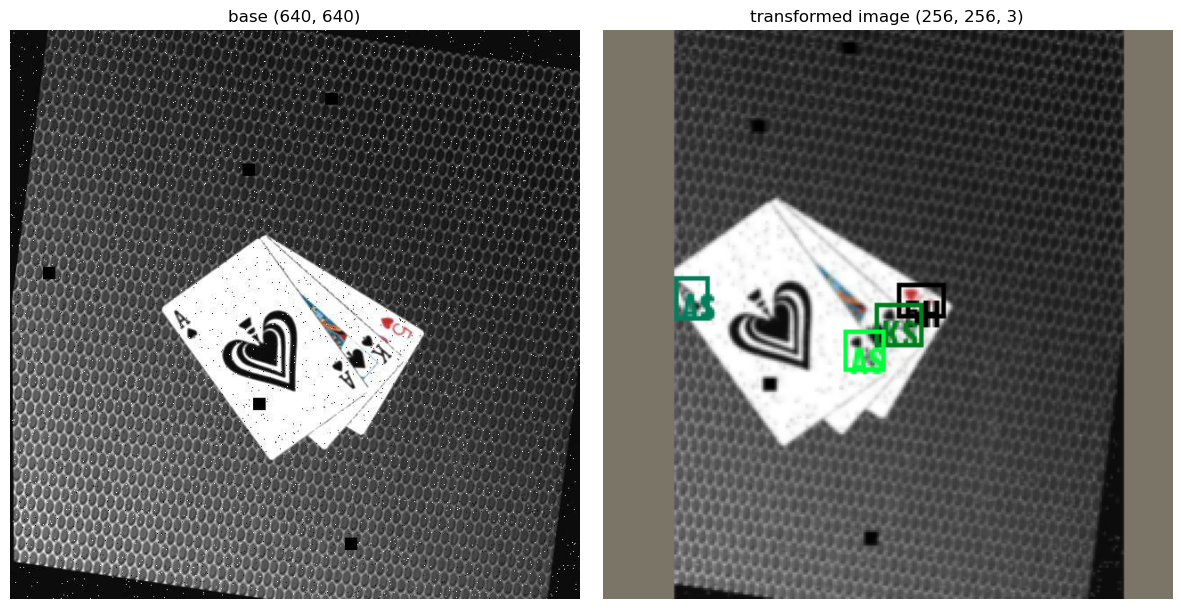

In [684]:
# printing the augmented image 


annotated_img = np.transpose(np.array(annotated_tensor), (1, 2, 0))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title(f'base {img.size}')

axs[1].imshow(annotated_img)
axs[1].axis('off')
axs[1].set_title(f'transformed image {annotated_img.shape}')

plt.tight_layout()
plt.show()

In [685]:
# let's wrap up all this stuff in a torchvision.transfroms.Compose and pass it to our Dataset:

# DATA AUGMENTATION
data_aug_tfms = transforms.Compose(
    transforms=[
        cropper, # the previous cropper we defined
        transforms.ColorJitter( # some color shuffle
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(), 
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5), # some rotations
    ],
)

# DATA TRANSFORMATION
resize_pad_tfm = transforms.Compose([
    resize_max, 
    padder,
    transforms.Resize([TRAIN_SIZE] * 2, antialias=True)
])

# DATA TRANSFORMATION
final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), # will normalize the pixels
    transforms.SanitizeBoundingBoxes(),
])

# GATHERING EVERYTHING
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

In [686]:
# lets check if our Dataset still instanciate:

test_tfsm = CardDlayingDataset(TRAIN_PATH, train_tfms)

<class 'torchvision.tv_tensors._image.Image'> <class 'dict'> torch.float32 torch.float32


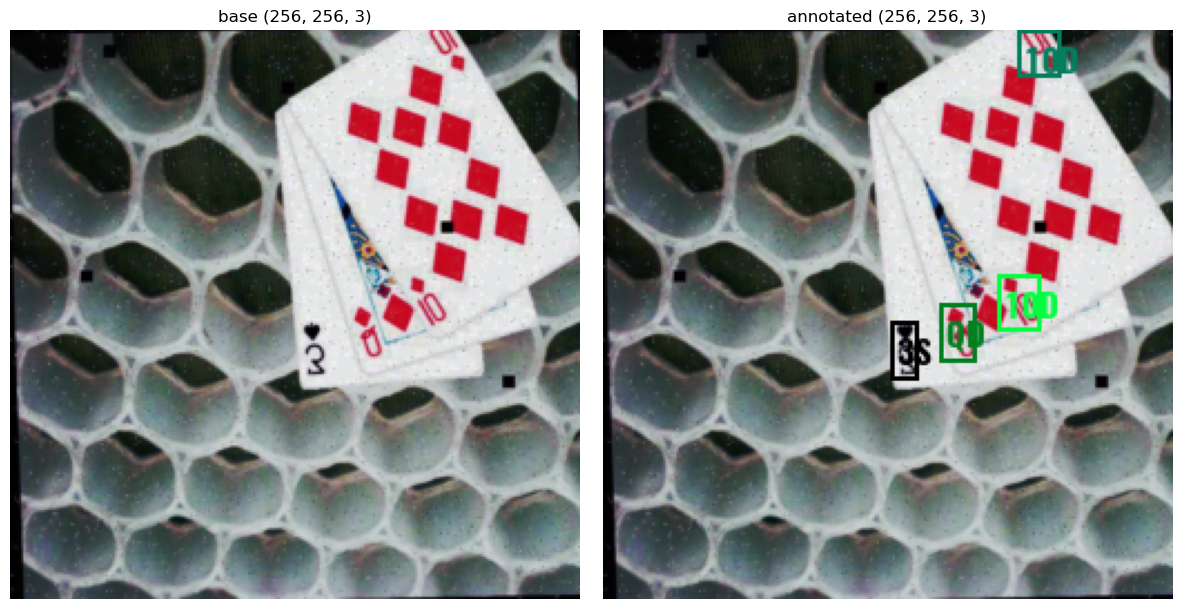

In [687]:
img, labels = test_tfsm[0]

print(type(img), type(labels), (labels['boxes'].dtype), (labels['labels'].dtype))

annotated_tensor = draw_bboxes(
    image = (img * 255).to(dtype=torch.uint8), 
    boxes = labels['boxes'], 
    labels = [train_dataset.classes_names[int(c)] for c in labels['labels']],
)

base_img = np.transpose(np.array(img), (1, 2, 0))
annotated_img = np.transpose(np.array(annotated_tensor), (1, 2, 0))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(base_img)
axs[0].axis('off')
axs[0].set_title(f'base {base_img.shape}')

axs[1].imshow(annotated_img)
axs[1].axis('off')
axs[1].set_title(f'annotated {annotated_img.shape}')

plt.tight_layout()
plt.show()